In [1]:
import sys, os
import torch
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import tools.utilities as utils # helper functions

import warnings; 
warnings.simplefilter('ignore')

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE'
  warn(f"Failed to load image Python extension: {e}")


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
COLAB = 'google.colab' in str(get_ipython())
COMPRESS = False

if not COLAB:
    path = 'data'
    img_src_path = os.path.join(path, 'GTSRB/Final_Training/Images')
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive//MyDrive/DL4CV-2022/GTSRB/'
    sys.path.insert(0, '/content/drive/MyDrive/DL4CV-2022/GTSRB/utilities')
    
!ls $path

GTSRB                           pbz2
GTSRB_Final_Test_Images.zip     signnames.csv
GTSRB_Final_Training_Images.zip traffic-signs-data.zip
Training


In [4]:
if COMPRESS:
    '''
    The pbz2 files below were read in and compressed and pickled using code
    adapted from: https://benchmark.ini.rub.de/gtsrb_dataset.html#Codesnippets.
    See p1_utilities.py file for details on the code. 
    '''
    trainImages = utils.decompress_pickle(path + '/pbz2/GTSRB-trainImages.pbz2') 
    trainLabels = utils.decompress_pickle(path + '/pbz2/GTSRB-trainLabels.pbz2') 
else:
    pass

#print ('Train images: ' + str(len(trainImages)) + ', Labels: ' + str(len(trainLabels)))

In [5]:
# Create Datasets
import loader.gtsrb_data as dataset
import random

trainset = dataset.GTSRB('./data')
train_dataloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=128, 
                                          shuffle=True, num_workers=2)

In [6]:
sign_names = utils.make_class_dict(path + '/signnames.csv')
classes = list(sign_names.values())

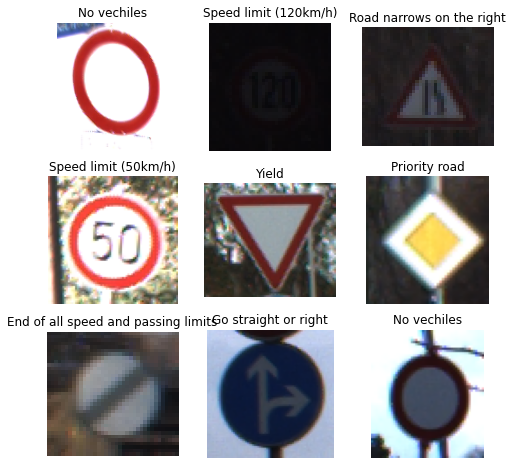

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(sign_names[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
''' GUTTER

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


# for automatic reloading and inline matplotlib
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#from sklearn.metrics import confusion_matrix

from PIL import Image

print (len(trainLabels), len(trainImages))


class GTSRBLoader(torch.utils.data.Dataset):

    def __init__(self, data_dir, split, custom_transforms=None, list_dir=None,
                 out_name=False,  crop_size=None, num_classes=43, phase=None):
        
        self.data_dir = data_dir
        self.split = split
        self.phase = split if phase is None else phase
        self.crop_size = 32 if crop_size is None else crop_size
        self.out_name = out_name
        self.idx2label = idx2label
        self.classnames = classnames

        self.num_classes = num_classes
        self.mean = np.array([0.3337, 0.3064, 0.3171])
        self.std = np.array([0.2672, 0.2564, 0.2629])
        self.image_list, self.label_list = None, None
        self.read_lists()
        self.transforms = self.get_transforms(custom_transforms)


    def __getitem__(self, index):
        im = Image.open(f'{self.data_dir}/{self.image_list[index]}')
        data = [self.transforms(im)]
        data.append(self.label_list[index])
        if self.out_name:
            data.append(self.image_list[index])
        return tuple(data)


    def __len__(self):
        return len(self.image_list)


    def get_transforms(self, custom_transforms):
        if custom_transforms:
            return custom_transforms

        if 'train' == self.phase:
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ]) 
        else: 
            return transforms.Compose([
                transforms.Resize((self.crop_size, self.crop_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.mean, std=self.std),
            ])   


    def read_lists(self):
        image_path = os.path.join(self.data_dir, self.split + '_images.txt')
        assert os.path.exists(image_path)
        self.image_list = [line.strip().split()[0] for line in open(image_path, 'r')]
        self.label_list = [int(line.strip().split()[1]) for line in open(image_path, 'r')]
        assert len(self.image_list) == len(self.label_list)

    
    # get raw image prior to normalization
    # expects input image as torch Tensor
    def unprocess_image(self, im, plot=False):
        im = im.squeeze().numpy().transpose((1, 2, 0))
        im = self.std * im + self.mean
        im = np.clip(im, 0, 1)
        im = im * 255
        im = Image.fromarray(im.astype(np.uint8))
        
        if plot:
            plt.imshow(im)
            plt.show()
        else:
            return im
  
    # de-center images and bring them back to their raw state
    def unprocess_batch(self, input):
        for i in range(input.size(1)):
            input[:,i,:,:] = self.std[i] * input[:,i,:,:]
            input[:,i,:,:] = input[:,i,:,:] + self.mean[i]
            input[:,i,:,:] = np.clip(input[:,i,:,:], 0, 1)

        return input
'''